In [4]:
import matplotlib
matplotlib.use('Agg')
%matplotlib inline

import os
import pandas as pd
import numpy as np
import sys
import pickle
from scipy.spatial.distance import cdist
import math
import networkx as nx
import networkx.algorithms.components.connected as nxacc
import networkx.algorithms.dag as nxadag
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import mygene
import re

In [5]:
def load_network(network_file_list, valid_gene_list):
    
    gene_neighbor_map = {}
    
    for file_name in network_file_list:
        
        ## print 'Load network', file_name
        
        file_handle = open(file_name)
    
        for line in file_handle:
        
            line = line.rstrip().split()
            gene1, gene2 = line[0], line[1]
        
            if gene1 not in valid_gene_list or gene2 not in valid_gene_list:
                continue
        
            if gene1 not in gene_neighbor_map:
                gene_neighbor_map[gene1] = set()
            if gene2 not in gene_neighbor_map:
                gene_neighbor_map[gene2] = set()
            
            gene_neighbor_map[gene1].add(gene2)
            gene_neighbor_map[gene2].add(gene1)
            
        file_handle.close()
    
    return gene_neighbor_map
                             
def load_name_space():
        
    go_tab_map = {}
    
    file_handle = open(go_name_space_file)
    
    for line in file_handle:
        line = line.rstrip().split()
        go_tab_map[line[0]] = line[1]
        
    file_handle.close()
    
    return go_tab_map
        
def list2index(cell_line_list, cell_line2id):
    
    cell_line_idx_list = []
    
    for cell_line in cell_line_list:
        cell_line_idx_list.append(cell_line2id[cell_line])
        
    return np.asarray(cell_line_idx_list)

In [14]:
data_file = '/data/PTDC/'
new_network_file = '/data/'

exp_data_file = data_file + 'ExpressionModels.tsv'

drug_cell_line_file = data_file + 'DrugResponsesAUCModels.tsv'
#download at https://ftp.sanger.ac.uk/pub4/cancerrxgene/releases/release-6.0/v17_fitted_dose_response.xlsx

#cell_line_detail_file = data_file + 'Cell_Lines_Details.csv'
mutation_data_file = data_file + 'SNVsModels.tsv'
drug_target_file ='/data/drug_targets.tsv'

feature_folder = 'feature/'

inbiomap_file = 'InBioMap_Symbol.sif'
pathwaycomm_file = 'PathwayCommons_Symbol.sif'

pd.set_option('display.max_columns', 20)
pd.set_option('display.max_row', 10)

In [69]:
exp_df = pd.read_csv(exp_data_file, sep='\t', index_col=0).fillna(0)
exp_df = exp_df.T[1:]
#exp_df = exp_df.rename(columns={np.nan: 'NO_GENE_NAME'})
#exp_df = exp_df.drop('NO_GENE_NAME',axis=1)

def stripNumber(line):
    m = re.match('DATA\.([0-9]+)\.?', line)
    return int(m.group(1))

#exp_df.index = exp_df.index.map(stripNumber)
#exp_df = exp_df.groupby(level=0).first()

exp_gene_list = list(exp_df.columns)
exp_cell_line_list = list(exp_df.index.unique())

# # print len(exp_cell_line_list), len(exp_gene_list)

exp_df

Gene,A1BG,A1CF,A2LD1,A2M,A3GALT2,A4GALT,A4GNT,AA057856,AA083069,AA177072,...,DCTN3,DCTN4,DCTN6,DCTPP1,DCUN1D1,DCUN1D2,DCUN1D3,DCUN1D4,DCUN1D5,DCX
AB551,5.830705,5.965247,6.931300,5.751998,5.856632,5.684931,6.014943,5.827945,6.115090,6.090251,...,9.958142,8.112496,8.375597,10.082973,7.726346,6.057067,8.036905,7.346654,9.285248,5.978613
AB555,5.989007,5.908758,7.036796,5.588598,5.965087,6.562636,6.047939,5.738294,6.143941,6.268883,...,10.386901,8.189543,8.817847,10.442520,8.086460,7.081238,7.454783,7.002433,8.395440,6.112057
AB559,5.953126,6.009367,7.170089,10.122724,5.837339,8.222053,6.179390,6.055652,6.184514,6.309170,...,9.148429,8.113212,8.925953,9.751634,7.827642,6.797036,6.989802,7.478812,9.083603,6.332593
AB580,5.928351,6.063145,6.207774,5.522242,5.826634,5.592881,6.135229,5.603115,6.031031,6.172038,...,9.942332,8.884296,8.019665,10.057062,8.318893,6.545253,7.921938,7.314085,9.188473,6.014324
AB630,5.805396,5.971214,6.137310,5.480885,6.036293,6.127859,6.147786,5.967121,6.113398,6.260791,...,10.444142,8.720334,8.276784,9.392276,7.834615,6.258318,7.633885,7.359484,9.656451,7.444550
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VHIO131,5.801763,5.931639,6.281433,5.582783,5.609380,7.262426,5.904006,5.788503,6.162989,6.347826,...,9.382848,8.590413,9.254976,10.003079,7.007442,6.420465,8.176424,7.153480,8.840495,0.000000
VHIO161,5.650367,5.920759,6.819061,10.508739,5.630920,7.411703,5.966186,5.636507,6.172530,5.999644,...,9.338628,7.971438,8.527100,10.462052,7.421056,6.447164,7.850504,6.884321,8.955288,0.000000
VHIO169,5.928900,5.986799,6.655561,7.829770,5.767358,6.493478,6.075501,5.859159,5.937670,6.194873,...,9.644100,7.920043,8.326174,10.365465,6.962486,6.630986,8.599206,7.367005,9.640723,0.000000
VHIO179,5.836068,5.919454,7.129801,6.345719,5.910645,6.022606,5.991640,5.842946,6.229808,6.129471,...,9.909389,7.940576,8.569851,10.888603,6.841573,6.883267,8.101469,8.095820,9.483269,0.000000


In [26]:
maf = pd.read_csv(mutation_data_file, sep='\t', index_col=0).fillna(0)
mutation_df= maf.replace(to_replace="NO",value=0.0)
mutation_df= mutation_df.replace(to_replace="chr*",value=1.0,regex=True)
# print len(mutation_cell_line_list), len(mutation_gene_list)
mutation_df = mutation_df.transpose()
mutation_gene_list = list(mutation_df.columns)
mutation_cell_line_list = list(mutation_df.index.unique())
mutation_df

Symbol,AGBL5,ALAS1,APOD,B4GALT2,BNIP3L,CACNA1F,CCDC149,CFDP1,CHD7,CHST6,...,TRA2A,TRADD,TRPV1,UBAC2,ULK2,URGCP,USB1,WBSCR17,ZNF79,ZNF804A
AB521M,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AB551,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AB555,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AB559,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AB580,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VHIO102,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
VHIO124,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
VHIO131IGFRES,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
VHIO179,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [27]:
file_handle = open(drug_target_file)

drug_target_map = {}
drug_target_list = []
for line in file_handle:
    
    new_line = line.rstrip().split("\t")
    drug = new_line[0]
    target_list=new_line[1].split(',')
    if drug != "Drug":
        target_list_str = ""
        for i in range(0,len(target_list)):
            if i == len(target_list) - 1:
                target_list_str += target_list[i].replace('"','')
            else:
                target_list_str += target_list[i].replace('"','') + ","
        drug = drug.strip()

        drug_target_map[drug] = []
        if ',' not in target_list_str:
            drug_target_map[drug].append(target_list_str.strip())
            drug_target_list.append(target_list_str.strip())
        else:
            target_list = target_list_str.split(',')
            for target in target_list:
                drug_target_map[drug].append(target.strip())
                drug_target_list.append(target.strip())

# print len(drug_target_list)
# print drug_target_map

In [29]:
drugs_legend = pd.read_csv('/data/GDSC/Screened_Compounds.csv', sep=',', index_col=0)

drug2id_mapping = {}

for index in list(drugs_legend.index) :
    drug_name = drugs_legend.loc[index,'Drug Name']
    drug2id_mapping[ drug_name ] = index


In [30]:
valid_gene_list = list(set(drug_target_list) | set(exp_gene_list) | set(mutation_gene_list))

network_list = [new_network_file+inbiomap_file, new_network_file+pathwaycomm_file]
gene_neighbor_map =  load_network(network_list, valid_gene_list)

In [31]:
gene_name_df = pd.read_table('/data/HUGO_protein-coding_gene.tsv',index_col=25, sep='\t')

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (31,38) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [32]:
gene_name_map = {}

for uniprot_gene in gene_name_df.index:
    ## print uniprot_gene
    if isinstance(uniprot_gene, type('aaa')) == False:
        continue
    
    if isinstance(gene_name_df.loc[uniprot_gene, 'symbol'], type('aaa')) == False:
        gene_name_map[uniprot_gene] = gene_name_df.loc[uniprot_gene, 'symbol'][0]
    else:
        gene_name_map[uniprot_gene] = gene_name_df.loc[uniprot_gene, 'symbol']

In [33]:
corum_df = pd.read_table(new_network_file + 'allComplexes.txt', index_col=0)

uniprot_gene_set = set()

for index in corum_df.index:
    
    if corum_df.loc[index, 'Organism'] != 'Human':
        continue
        
    complex_list = corum_df.loc[index, 'subunits(UniProt IDs)'].split(';')
    
    for gene in complex_list:
        uniprot_gene_set.add(gene)

# print len(uniprot_gene_set), 'genes'

query_gene_set = []

for gene in uniprot_gene_set:
    if gene not in gene_name_map:
        query_gene_set.append(gene)
    
# print 'Need to query', len(query_gene_set)

query_gene_list = list(query_gene_set)

mg = mygene.MyGeneInfo()
out = mg.querymany(query_gene_list, scopes='uniprot', fields='symbol', species='human')

not_found_gene_list = []

for i, gene in enumerate(query_gene_list):
    if 'notfound' in out[i]:
        not_found_gene_list.append(gene)
    else:
        gene_name_map[gene] = out[i]['symbol']
        
# print len(not_found_gene_list), 'symbol name not found', len(gene_name_map)

querying 1-43...done.
Finished.
1 input query terms found dup hits:
	[('P01871', 2)]
25 input query terms found no hit:
	['Q13745', 'A6QQ77', 'Q16198', 'P62158', 'Q1EHW4', 'Q9NY11', 'Q9NZL9-', 'P48830', 'Q9Z176', 'Q13791'
Pass "returnall=True" to return complete lists of duplicate or missing query terms.


In [34]:
corum_df = pd.read_table(new_network_file + 'allComplexes.txt', index_col=0)

for index in corum_df.index:
    
    if corum_df.loc[index, 'Organism'] != 'Human':
        continue
    
    complex_list = corum_df.loc[index, 'subunits(UniProt IDs)'].split(';')
    
    complex_symbol_list = []
    
    for gene in complex_list:
        if gene in gene_name_map:
            complex_symbol_list.append( gene_name_map[gene] )

    for gene1, gene2 in itertools.combinations(complex_symbol_list,2):
        
        if gene1 not in gene_neighbor_map:
            gene_neighbor_map[gene1] = set()
        if gene2 not in gene_neighbor_map:
            gene_neighbor_map[gene2] = set()
        
        gene_neighbor_map[gene1].add(gene2)
        gene_neighbor_map[gene2].add(gene1)

In [35]:
gene_exp_neighbor_map = {}
exp_matrix = exp_df.values

P = 1 - cdist(np.transpose(exp_matrix), np.transpose(exp_matrix),'correlation')

for i in range(len(exp_gene_list)):
    
    gene1 = exp_gene_list[i]
    gene_exp_neighbor_map[gene1] = set()
    
    for j in range(len(exp_gene_list)):
        
        gene2 = exp_gene_list[j]
        
        if math.fabs(P[i, j]) > 0.4:
            gene_exp_neighbor_map[gene1].add(gene2)
            
    if gene1 not in gene_exp_neighbor_map[gene1]:
        print (gene1, 'not in itself?', P[i,i])

AI458759 not in itself? nan
AK127905 not in itself? nan
C14orf55 not in itself? nan
CT47A1 not in itself? nan
DCX not in itself? nan


In [37]:
selected_drugs = pd.read_csv("/data/Selected Drugs.csv")["Drug name"].tolist()

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:>

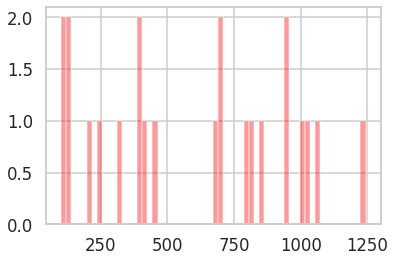

In [38]:
drug_feature_list = []
drug_neighbor_map = {}
selected_drug_list = []

for drug, target_list in drug_target_map.items():
    if drug in selected_drugs:
        drug_neighbor_map[drug] = set()

        for gene in target_list:

            if gene not in gene_exp_neighbor_map and gene not in gene_neighbor_map:
                continue

            if gene in gene_exp_neighbor_map:
                drug_neighbor_map[drug] = drug_neighbor_map[drug] | gene_exp_neighbor_map[gene]

            if gene in gene_neighbor_map:
                drug_neighbor_map[drug] = drug_neighbor_map[drug] | gene_neighbor_map[gene]

        if len(drug_neighbor_map[drug]) != 0:
             selected_drug_list.append(drug)
             drug_feature_list.append( len(drug_neighbor_map[drug]) )
sns.set_style("whitegrid")
sns.set_context("talk")
sns.distplot(drug_feature_list,color='r',bins=60,kde=False,norm_hist=False)

In [44]:
drugs = pd.read_csv(drug_cell_line_file,sep='\t',index_col=0)
drugs_cell_line_list = list(drugs.index.unique())
# print len(drugs_cell_line_list)
drugs

#cell_line_drug_matrix = drugs.loc[drugs['DRUG_ID'] == 1026]
#cell_line_drug_matrix.loc[[924100,910924],'LN_IC50'].values

#cell_line_drug_matrix.loc[ [909758, 924247, 924107],'DRUG_ID' ]

,Drug,AUC,iC50,D1_CONC,D5_CONC,perc.iC50
Model,,,,,,
HCI001,(5Z)-7-Oxozeaenol,0.217813,5.483270e+00,7.701322,2.337740,71.507443
HCI001,17-AAG,0.301919,1.834974e+04,1.000000,0.003906,183.038003
HCI001,5-Fluorouracil,0.494210,1.350264e+00,20.000000,0.078125,51.391421
HCI001,681640,0.102932,1.521258e+02,2.000000,0.007812,150.681089
HCI001,ABT-263,0.497307,1.246564e-01,2.000000,0.007812,49.591347
...,...,...,...,...,...,...
VHIO244,Vorinostat,0.560835,4.783231e-01,10.000000,0.039062,44.636232
VHIO244,XAV 939,0.080441,1.033271e+05,5.581430,1.175631,702.942004
VHIO244,YK 4-279,0.216032,8.690911e+00,7.701322,2.337740,79.903643


In [45]:
cell_line_list = list(set(drugs_cell_line_list)&set(exp_cell_line_list)&set(mutation_cell_line_list) )
print(len(cell_line_list))

19


In [46]:
# cell_line_legend = pd.read_csv(cell_line_detail_file, index_col=1)
# ## print cell_line_legend

# tissue_map = {}

# for cell_line in cell_line_list:
    
#     tissue = cell_line_legend.loc[cell_line,'Site']
    
#     if tissue not in tissue_map:
#         tissue_map[tissue] = []
        
#     tissue_map[tissue].append(cell_line)

# large_tissue_number = 0
# for tissue, cell_line in tissue_map.items():
    
#     if len(cell_line) >= 15:
#         large_tissue_number += 1
    
#     print (tissue, len(cell_line))
tissue_map = {'breast':cell_line_list}

# print 'How many tissues', len(tissue_map)
# print 'Large tissues', large_tissue_number

'''
file_handle = open(data_file + "sanger_tissue_cell_line_list.pkl","wb")
pickle.dump(tissue_map,file_handle)
file_handle.close()
'''

'\nfile_handle = open(data_file + "sanger_tissue_cell_line_list.pkl","wb")\npickle.dump(tissue_map,file_handle)\nfile_handle.close()\n'

In [47]:
tissue_map

{'breast': ['HCI008',
  'HCI011',
  'HCI009',
  'VHIO098',
  'STG139M',
  'HCI002',
  'STG282',
  'IC007',
  'STG139',
  'STG316',
  'VHIO244',
  'STG201',
  'HCI010',
  'HCI005',
  'STG143',
  'STG195',
  'VHIO179',
  'HCI001',
  'STG335']}

In [ ]:
drug = "Sorafenib"
cell_line_drug_matrix = drugs.loc[drugs['Drug'] == drug]
feature_exp_gene_list = list( set(drug_neighbor_map[drug]) & set(filtered_exp_gene_list))
feature_mut_gene_list = list( set(drug_neighbor_map[drug]) & set(filtered_mut_gene_list))

In [94]:
new_data_file = ''

# print mutation_df.shape, exp_df.shape

exp_stdev = np.std(exp_df.values, axis=0)
exp_perc = np.percentile(exp_stdev,10)
filtered_exp_gene_list = np.asarray(exp_gene_list)[exp_stdev > exp_perc]

mut_sum = np.sum(mutation_df.values,axis=0)
filtered_mut_gene_list = np.asarray(mutation_gene_list)[mut_sum > 5]

# print np.sum(exp_stdev > exp_perc), np.sum(mut_sum > 5)#, np.sum(cnv_stdev > cnv_perc)

#new_exp_df = exp_df.loc[ cell_line_list, list(filtered_exp_gene_list) ]
#new_mutation_df = mutation_df.loc[ cell_line_list, list(filtered_mut_gene_list) ]

new_exp_df = exp_df.loc[ :, list(filtered_exp_gene_list) ]
new_mutation_df = mutation_df.loc[ :, list(filtered_mut_gene_list) ]

#cell_line2id = dict(zip(cell_line_list, range(len(cell_line_list))))

rename_selected_drug_list = []

for drug in selected_drug_list:
    print(drug)
#     if drug != 'Nutlin-3a (-)':
#         continue
    
    if drug not in drug2id_mapping:
        print('drug name wrong', drug)
    else:
        cell_line_drug_matrix = drugs.loc[drugs['Drug'] == drug]

        ## print cell_line_drug_matrix

        feature_exp_gene_list = list( set(drug_neighbor_map[drug]) & set(filtered_exp_gene_list) )
        feature_mut_gene_list = list( set(drug_neighbor_map[drug]) & set(filtered_mut_gene_list) )
        print(len(feature_exp_gene_list) + len(feature_mut_gene_list))
        if len(feature_exp_gene_list) + len(feature_mut_gene_list) == 0:
            continue
        feature_description = []

        drug_tissue_map = {}

        drug = drug.replace(' ','_')

        rename_selected_drug_list.append(drug)

        # print drug
        if drug == 'Nutlin-3a_(-)':
            drug = 'Nutlin-3a'

        drug_folder = '/data/drug_feature/' + drug + '/'
        if not os.path.exists(drug_folder):
            os.makedirs(drug_folder)

        # print 'Generate features', drug

        for tissue, tissue_cell_line_list in tissue_map.items():

            drug_specific_cell_line = set( cell_line_drug_matrix.index ) & set( tissue_cell_line_list )
            drug_specific_cell_line = list(drug_specific_cell_line)
            drug_tissue_map[tissue] = drug_specific_cell_line

            feature_list = []

            if len(feature_exp_gene_list) != 0:
                feature_list.append(new_exp_df.loc[ drug_specific_cell_line, feature_exp_gene_list ].values)
                #for gene in feature_exp_gene_list:
                    #feature_description.append(gene+'_expression')

            if len(feature_mut_gene_list) != 0:
                feature_list.append( mutation_df.loc[ drug_specific_cell_line, feature_mut_gene_list ].values )
                #for gene in feature_mut_gene_list:
                    #feature_description.append(gene+'_mutation')

            feature = np.concatenate(feature_list, axis=1)

            label = cell_line_drug_matrix.loc[ drug_specific_cell_line,'LN_IC50'].values

            #label = new_crispr_df.loc[ tissue_cell_line_list, label_gene ].values

            # print feature.shape, label.shape

            np.save(drug_folder + 'PDTC_' + drug + '_feature.npy', feature )
            np.save(drug_folder + 'PDTC' + '_' + drug + '_label.npy', label)
            #np.save(drug_folder + tissue + '_feature_description.npy', np.asarray(feature_description))

        file_handle = open(new_data_file + drug+'_tissue_cell_line_list.pkl',"wb")
        pickle.dump(drug_tissue_map,file_handle)
        file_handle.close()
    
file_handle = open('rename_selected_drug_list', 'w')
for drug in rename_selected_drug_list:
    file_handle.writelines(drug+ '\n')
file_handle.close()


681640
613
AG-014699
drug name wrong AG-014699
AMG-706
drug name wrong AMG-706
Axitinib
47
AZ628
329
AZD7762
783
Bosutinib
306
BX-795
drug name wrong BX-795
Camptothecin
56
CEP-701
drug name wrong CEP-701
CHIR-99021
142
Embelin
51
Gefitinib
332
JNJ-26854165
drug name wrong JNJ-26854165
JQ1
613
KU-55933
597
MK-2206
713
PD-0332991
drug name wrong PD-0332991
PD-173074
drug name wrong PD-173074
PLX4720
drug name wrong PLX4720
RO-3306
692
Sorafenib
47
ZM-447439
drug name wrong ZM-447439


In [80]:
drug_specific_cell_line

[]

In [85]:
len(drug_specific_cell_line)

1

In [86]:
len(drug_tissue_map['breast'])

14

In [87]:
import pickle

In [37]:
cell_line_loc = '/cellar/users/samsonfong/Projects/tcrp-v2/from-ma/cell_line_lists/'

In [38]:
with open('/data/drug_feature/KU-55933/KU', 'rb') as f: 
    tmap= pickle.load(f)

In [59]:
filtered_exp_gene_list

array([], dtype='<U24')

In [49]:
len(tmap['lung'])

137

In [96]:
f = np.load("/data/drug_feature/Sorafenib/PDTC_Sorafenib_feature.npy",allow_pickle=True)